In [1]:
# libraries
import os
import time
import random
import numpy as np
import pandas as pd
import subprocess
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score
from warmup_scheduler import GradualWarmupScheduler
import albumentations
import timm
from tqdm.notebook import tqdm
import torch.cuda.amp as amp
import warnings

warnings.simplefilter('ignore')
scaler = amp.GradScaler()
device = torch.device('cuda')

In [57]:
DEBUG = False
kernel_type = 'enetb1_5ch_512_lr3e4_bs32_30epo'
enet_type = 'tf_efficientnet_b1_ns'
data_dir = '../xray_image'
num_workers = 2
num_classes = 12
n_ch = 4
image_size = 512
batch_size = 32
init_lr = 3e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 29 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo
loss_weights = [1., 9.]
image_folder = 'train'
mask_folder = '../generated_mask/'

log_dir = 'logs_classificarion'
model_dir = 'models_classification'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'log_{kernel_type}.txt')

In [12]:
train_df = pd.read_csv(os.path.join(data_dir,'train.csv')).drop('PatientID', axis=1)
train_df.shape

(30083, 12)

In [13]:
train_df[train_df.columns[1:4]].sum(axis=1).sum()

8457

In [14]:
train_df['ETT-No']=1-train_df[train_df.columns[1:4]].sum(axis=1)

In [15]:
train_df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,ETT-No
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,0
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,1
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,1
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,1


In [16]:
all_files = train_df.StudyInstanceUID.unique()
len(all_files)

30083

In [29]:
train_df[[
                'ETT - Abnormal',
                'ETT - Borderline',
                'ETT - Normal',
                'ETT-No',
                'NGT - Abnormal',
                'NGT - Borderline',
                'NGT - Incompletely Imaged',
                'NGT - Normal',
                'CVC - Abnormal',
                'CVC - Borderline',
                'CVC - Normal',
                'Swan Ganz Catheter Present'
            ]]

,ETT - Abnormal,ETT - Borderline,ETT - Normal,ETT-No,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,0,0,0,1,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
30078,0,0,1,0,0,0,0,0,0,1,1,0
30079,0,0,0,1,0,0,0,0,0,0,1,0
30080,0,0,1,0,0,0,1,0,1,0,1,0
30081,0,0,0,1,0,0,0,0,0,1,0,0


In [35]:
X = train_df.StudyInstanceUID
y = train_df[[
                'ETT - Abnormal',
                'ETT - Borderline',
                'ETT - Normal',
                'ETT-No',
                'NGT - Abnormal',
                'NGT - Borderline',
                'NGT - Incompletely Imaged',
                'NGT - Normal',
                'CVC - Abnormal',
                'CVC - Borderline',
                'CVC - Normal',
                'Swan Ganz Catheter Present'
            ]].to_numpy()

In [53]:
len(X)

30083

In [36]:
y[0]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [54]:
class RANZCRDatasetCLS(Dataset):

    def __init__(self, X,y, mode, transform=None):

        self.X = X
        self.y = y
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(X)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(data_dir, image_folder, X[index] + '.jpg'))[:, :, ::-1]
        mask = cv2.imread(os.path.join(mask_folder, X[index] + '.png')).astype(np.float32)[:,:,:1]

        res = self.transform(image=image, mask=mask)
        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.
        mask = res['mask'].astype(np.float32).transpose(2, 0, 1) / 255.

        image = np.concatenate([image, mask], 0)

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            label = y[index].astype(float)
            return torch.tensor(image).float(), torch.tensor(label).float()

In [55]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    #albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.2, p=0.75),
    albumentations.RandomContrast(limit=0.2, p=0.75),

    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.75),

    albumentations.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=40, val_shift_limit=0, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=30, border_mode=0, p=0.75),
    #CutoutV2(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.75),
])
transforms_val = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

In [46]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(8, 8))
    for i, (name, image) in enumerate(images.items()):
        if image.shape[0] == 3:
            image = image.numpy()
            image = image.transpose((1,2,0))
        elif image.shape[0] == 1:
            image = image.numpy()
            image = image.reshape(image.shape[1],image.shape[2])
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [47]:
dataset_show = RANZCRDatasetCLS(X,y,'train', transform=transforms_train)

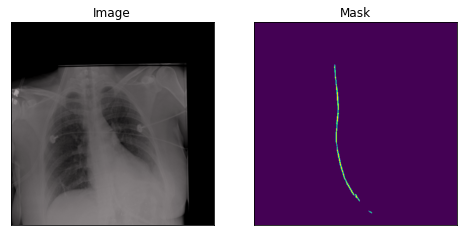

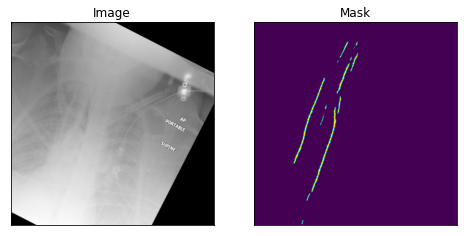

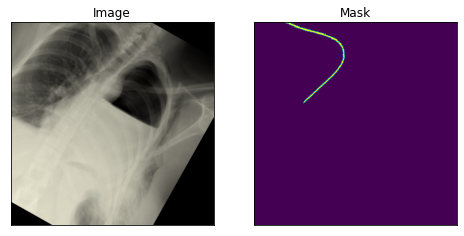

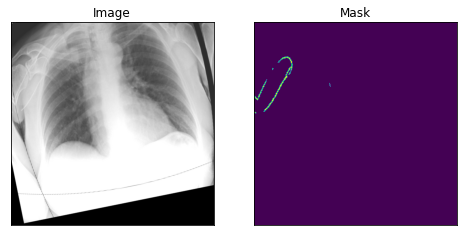

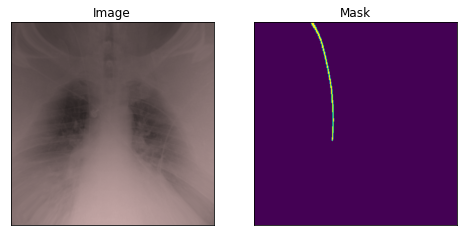

In [49]:
for i in range(5):
    image, mask = dataset_show[i]
    visualize(image=image[:3].transpose(0, 1).transpose(1,2),
             mask= image[3:].sum(0))

In [58]:
class enetv2(nn.Module):
    def __init__(self, enet_type, out_dim):
        super(enetv2, self).__init__()
        self.enet = timm.create_model(enet_type, True)
        self.dropout = nn.Dropout(0.5)
        self.enet.conv_stem.weight = nn.Parameter(self.enet.conv_stem.weight.repeat(1,n_ch//3+1,1,1)[:, :n_ch])
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        h = self.myfc(self.dropout(x))
        return h

m = enetv2(enet_type, num_classes)
m(torch.rand(2,n_ch,image_size, image_size))

tensor([[-0.0124, -0.1720, -0.1371,  0.0734, -0.1606,  0.0316, -0.1314, -0.0536,
         -0.1479, -0.2196, -0.1783, -0.1421],
        [ 0.0413,  0.0074, -0.0780,  0.0790, -0.0386, -0.0355,  0.0522,  0.0026,
          0.0948, -0.0691, -0.1320,  0.0571]], grad_fn=<AddmmBackward>)

In [59]:
bce = nn.BCEWithLogitsLoss()
ce = nn.CrossEntropyLoss()


def criterion(logits, targets, lw=loss_weights):
    loss1 = ce(logits[:, :4], targets[:, :4].argmax(1)) * lw[0]
    loss2 = bce(logits[:, 4:], targets[:, 4:]) * lw[1]
    return (loss1 + loss2) / sum(lw)

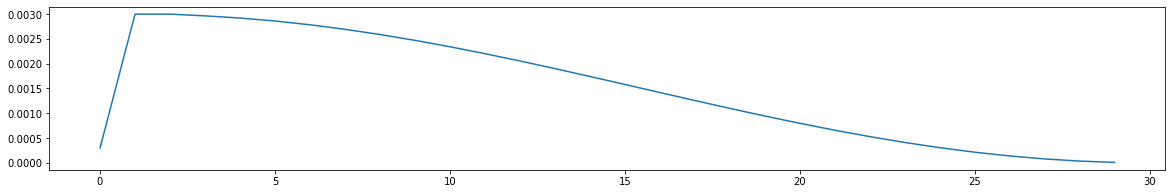

In [60]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

optimizer = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [61]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, targets) in bar:

        optimizer.zero_grad()
        data, targets = data.to(device), targets.to(device)

        with amp.autocast():
            logits = model(data)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scaler.update()

        loss_np = loss.item()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-50:]) / min(len(train_loss), 50)
        bar.set_description('loss: %.4f, smth: %.4f' % (loss_np, smooth_loss))

    return np.mean(train_loss)


def valid_epoch(model, loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    TARGETS = []
    with torch.no_grad():
        for (data, targets) in tqdm(loader):
            data, targets = data.to(device), targets.to(device)
            logits = model(data)
            loss = criterion(logits, targets)
            val_loss.append(loss.item())
            LOGITS.append(logits.cpu())
            TARGETS.append(targets.cpu())
            
    val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS)
    LOGITS[:, :4] = LOGITS[:, :4].softmax(1)
    LOGITS[:, 4:] = LOGITS[:, 4:].sigmoid()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return LOGITS
    else:
        aucs = []
        for cid in range(num_classes):
            if cid == 3: continue
            try:
                aucs.append( roc_auc_score(TARGETS[:, cid], LOGITS[:, cid]) )
            except:
                aucs.append(0.5)
        return val_loss, aucs

In [62]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state = 42, test_size = 0.2)

In [63]:
fold = 1 
content = 'Fold: ' + str(fold)
print(content)
with open(log_file, 'a') as appender:
    appender.write(content + '\n')
dataset_train = RANZCRDatasetCLS(X_train,y_train, 'train', transform=transforms_train)
dataset_valid = RANZCRDatasetCLS(X_val,y_val, 'valid', transform=transforms_val)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = enetv2(enet_type, num_classes)
model = model.to(device)
aucs_max = 0
model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')

optimizer = optim.Adam(model.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler_warmup.step(epoch-1)

    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss, aucs = valid_epoch(model, valid_loader)

    content = time.ctime() + ' ' + f'Fold {fold} Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.4f}, valid loss: {(val_loss):.4f}, aucs: {np.mean(aucs):.4f}.'
    content += '\n' + ' '.join([f'{x:.4f}' for x in aucs])
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')

    if aucs_max < np.mean(aucs):
        print('aucs increased ({:.6f} --> {:.6f}).  Saving model ...'.format(aucs_max, np.mean(aucs)))
        torch.save(model.state_dict(), model_file)
        aucs_max = np.mean(aucs)

torch.save(model.state_dict(), os.path.join(model_dir, f'{kernel_type}_model_fold{fold}.pth'))

Fold: 1
Thu Apr 29 03:24:15 2021 Epoch: 1


  0%|          | 0/941 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 7.43 GiB total capacity; 6.67 GiB already allocated; 50.81 MiB free; 6.69 GiB reserved in total by PyTorch)